In [1]:
# Local Imports
from src.utils.consts import RAW_DATASET
from src.utils.calculations import standard_deviation_bounds

from src.data.image_utils import get_image_array, resize_image
from src.data.data_entry_utils import remove_age_outliers, split_finding_labels

# Packages Imports
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Data Entry Data Analysis
# This data contains patients data, as well as image metadata
# Each data entry points to one image from `images/`
data_entry_file = f"{RAW_DATASET}/Data_Entry_2017.csv"
data_entry_df = pd.read_csv(data_entry_file, delimiter=',')

In [3]:
# Gender 
def get_gender_label(gender, count):
    label_map = {'M': 'Mężczyźni', 'F': 'Kobiety'}
    return f"{label_map.get(gender, 'Inne')} ({count})"

def create_gender_pie(ax, data, title):
    labels = [get_gender_label(gender, count) for gender, count in zip(data.index, data)]
    ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(title)    

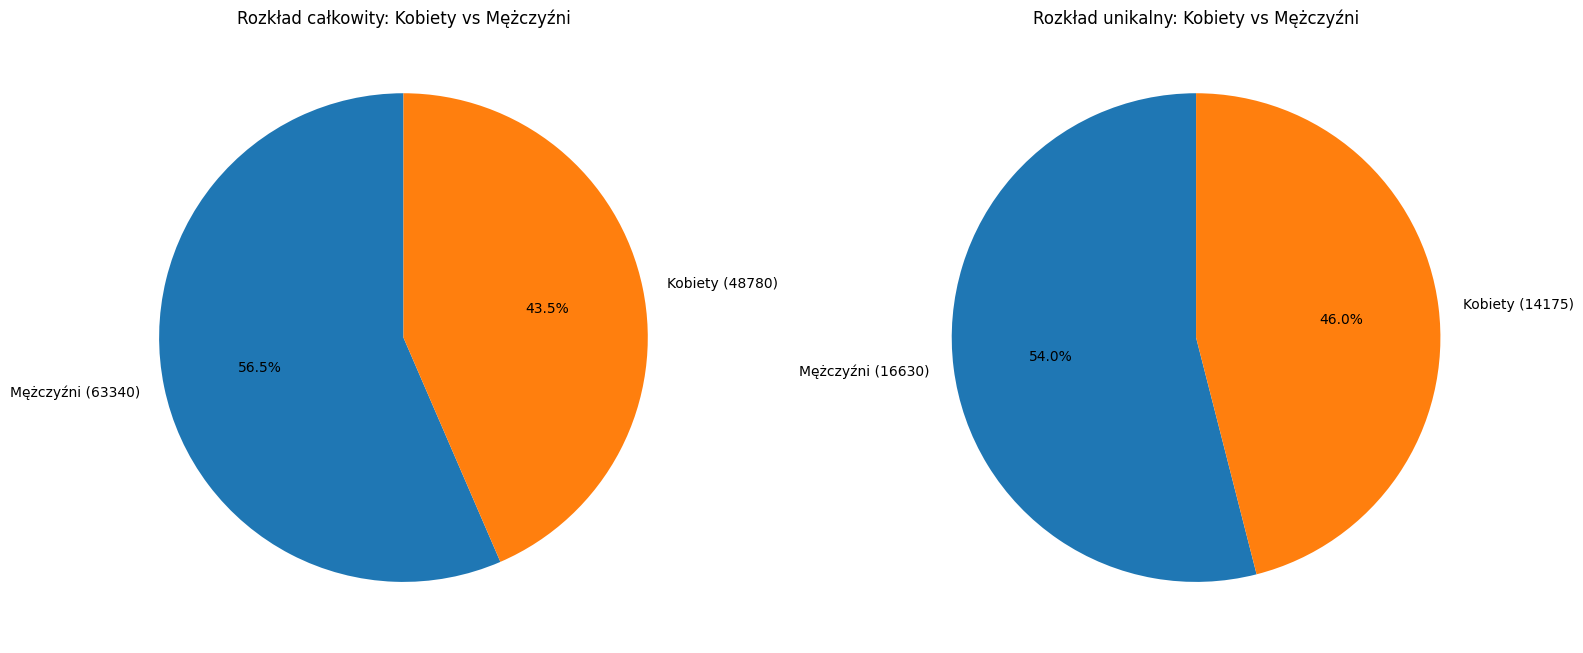

In [4]:
# Analyze Patients Gender
total_gender_counts = data_entry_df['Patient Gender'].value_counts()
unique_gender_counts = data_entry_df.groupby('Patient ID')['Patient Gender'].first().value_counts()

# Visualization (in its own cell)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

create_gender_pie(ax1, total_gender_counts, "Rozkład całkowity: Kobiety vs Mężczyźni")
create_gender_pie(ax2, unique_gender_counts, "Rozkład unikalny: Kobiety vs Mężczyźni")

plt.tight_layout()
plt.show()

In [5]:
def plot_age_histogram(ax, data, title, upper_bound=None):
    ax.hist(data, bins=range(0, int(data.max()) + 5, 5), edgecolor='black', alpha=0.75)
    ax.set_xlabel("Wiek (unikalni pacjenci)")
    ax.set_ylabel("Liczba pacjentów")
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if upper_bound:
        ax.axvline(upper_bound, color='red', linestyle='--', label=f'3σ Próg: {upper_bound:.2f}')
        ax.legend()

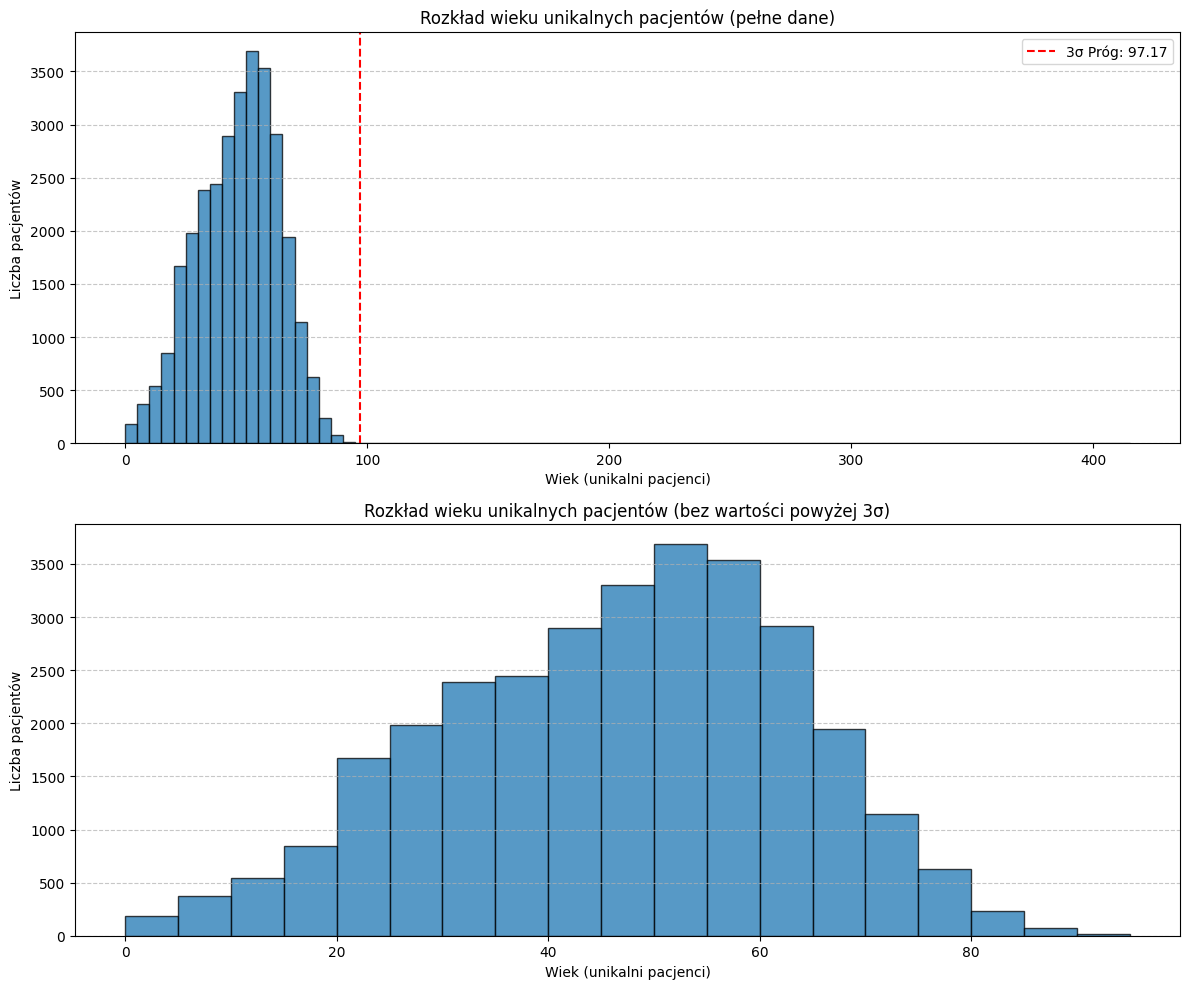

In [6]:
# Filter data to exclude outliers above the 3σ threshold
unique_patient_ages = data_entry_df.groupby('Patient ID')['Patient Age'].first()
filtered_unique_patient_ages, upper_bound = remove_age_outliers(unique_patient_ages, 3)

# Draw Histogram Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# First subplot: Original data with standard deviation threshold
plot_age_histogram(ax1, unique_patient_ages, "Rozkład wieku unikalnych pacjentów (pełne dane)", upper_bound)
# Second subplot: Filtered data with better accuracy
plot_age_histogram(ax2, filtered_unique_patient_ages, "Rozkład wieku unikalnych pacjentów (bez wartości powyżej 3σ)")

# Adjust layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()

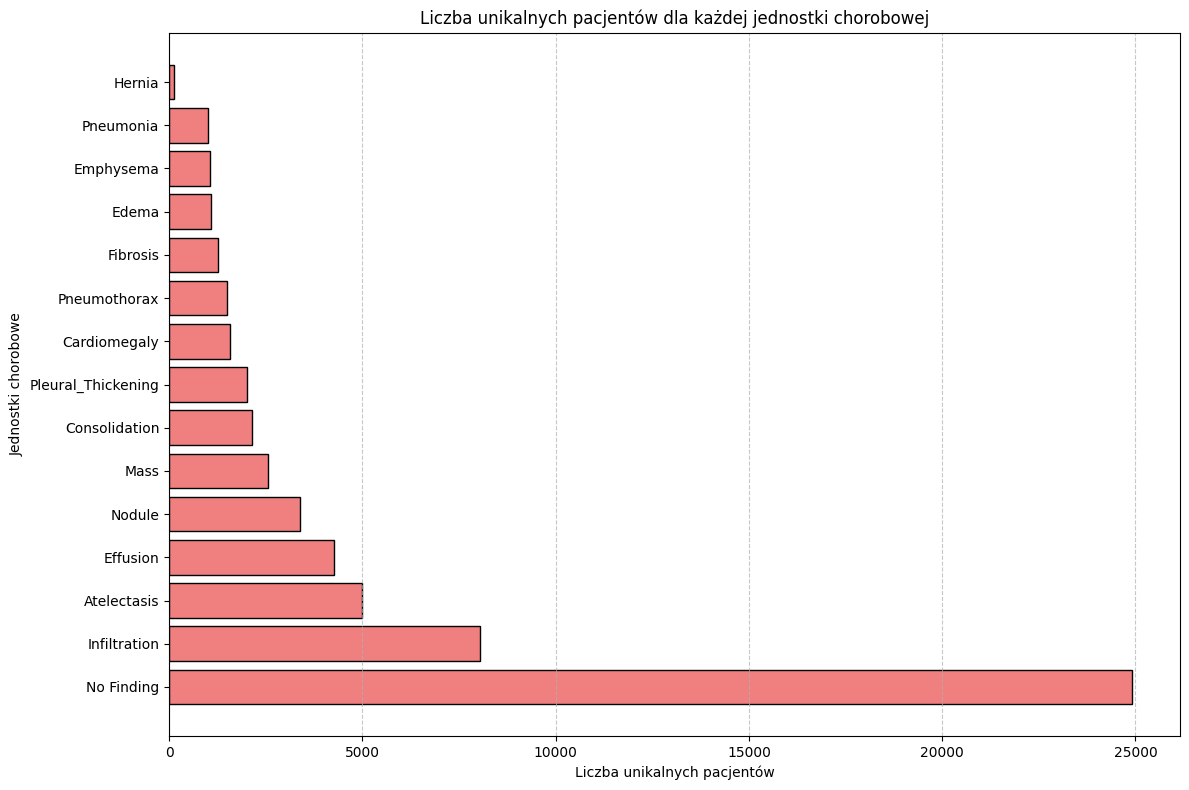

In [7]:
# Count unique patient occurrences for each disease
data_entry_df = split_finding_labels(data_entry_df)
unique_patient_labels = data_entry_df.copy()
unique_patient_labels = unique_patient_labels.groupby(['Patient ID']).agg({
    'Split Labels': lambda x: set([label for sublist in x for label in sublist])
}).explode('Split Labels').reset_index()
unique_disease_patient_count = unique_patient_labels['Split Labels'].value_counts()

# Draw Plot for Dieases Count
plt.figure(figsize=(12, 8))
plt.barh(unique_disease_patient_count.index, unique_disease_patient_count.values, color='lightcoral', edgecolor='black')
plt.xlabel("Liczba unikalnych pacjentów")
plt.ylabel("Jednostki chorobowe")
plt.title("Liczba unikalnych pacjentów dla każdej jednostki chorobowej")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# Bounding Box Data set
# This data contains limited amount of bounding boxes for images
# Each bounding box have only one dieases label
bounding_box_file = f"{RAW_DATASET}/BBox_List_2017.csv"
bounding_box_df = pd.read_csv(bounding_box_file, delimiter=',')

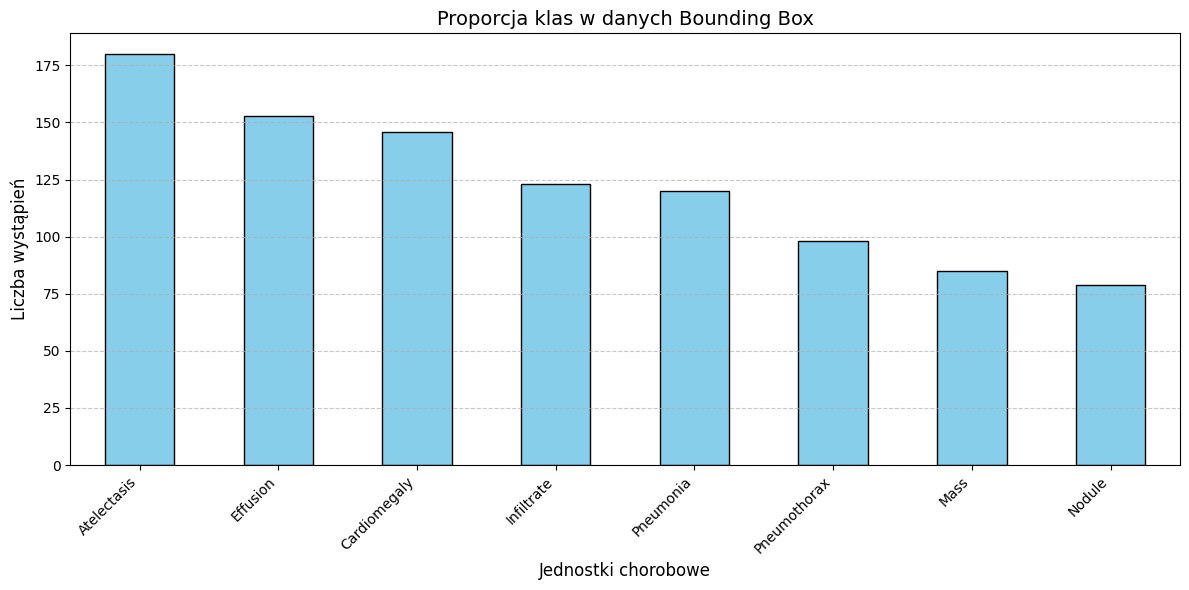

In [9]:
# Analyse Bounding Boxes Lables
bbox_class_counts = bounding_box_df['Finding Label'].value_counts()

# Draw Plot for Dieases Count
plt.figure(figsize=(12, 6))
bbox_class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Proporcja klas w danych Bounding Box", fontsize=14)
plt.xlabel("Jednostki chorobowe", fontsize=12)
plt.ylabel("Liczba wystąpień", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
def plot_histogram(ax, data, upper_bound, color, label, line):    
    plt.hist(data, bins=50, alpha=0.7, label=label, color=color, edgecolor='black')
    plt.axvline(upper_bound, color='red', linestyle=line, label=f'3σ Próg: {upper_bound:.2f}')

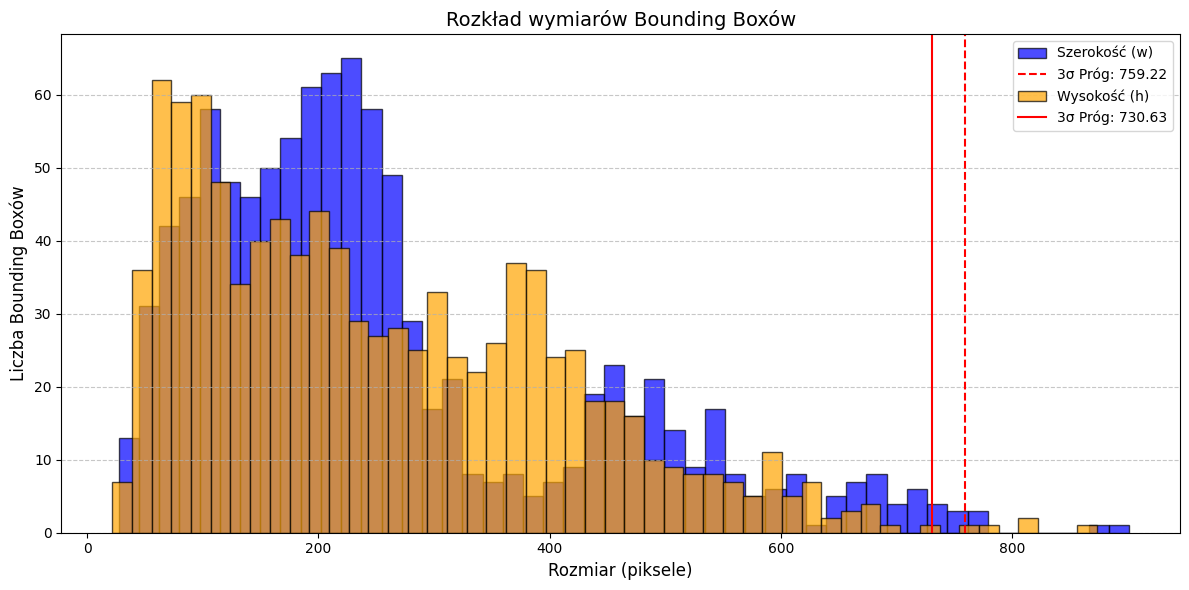

In [11]:
# Analyse Bounding Boxes size data

# Calculate 3std deviation for width
width_mean = bounding_box_df['w'].mean()
width_std  = bounding_box_df['w'].std()
_lower_bound, upper_width_bound = standard_deviation_bounds(width_mean, width_std, 3)

# Calculate 3std deviation for width
height_mean = bounding_box_df['h]'].mean()
height_std  = bounding_box_df['h]'].std()
_lower_bound, upper_height_bound = standard_deviation_bounds(height_mean, height_std, 3)

# Draw Histogram plot
plt.figure(figsize=(12, 6))

# Width
plot_histogram(plt, bounding_box_df['w'], upper_width_bound, 'blue', 'Szerokość (w)', '--')
plot_histogram(plt, bounding_box_df['h]'], upper_height_bound, 'orange', 'Wysokość (h)', '-')

plt.title("Rozkład wymiarów Bounding Boxów", fontsize=14)
plt.xlabel("Rozmiar (piksele)", fontsize=12)
plt.ylabel("Liczba Bounding Boxów", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

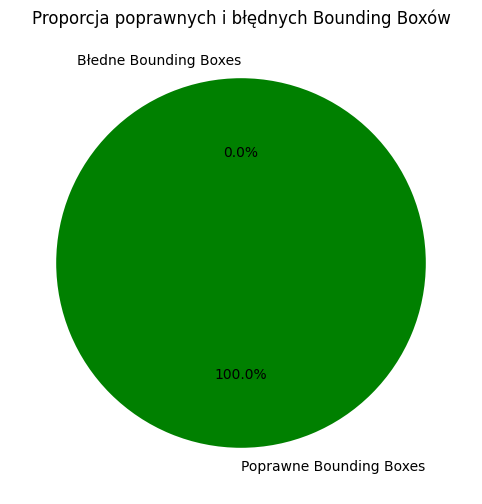

In [12]:
# Validate bounding boxes
valid_bboxes = bounding_box_df[(bounding_box_df['w'] > 0) & (bounding_box_df['h]'] > 0)]
invalid_bboxes = bounding_box_df[(bounding_box_df['w'] <= 0) | (bounding_box_df['h]'] <= 0)]

# Counts for valid and invalid bounding boxes
valid_bbox_count = len(valid_bboxes)
invalid_bbox_count = len(invalid_bboxes)

# Data for the pie chart
bbox_counts = [valid_bbox_count, invalid_bbox_count]
labels = ['Poprawne Bounding Boxes', 'Błedne Bounding Boxes']
colors = ['green', 'red']

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(bbox_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Proporcja poprawnych i błędnych Bounding Boxów")
plt.show()

In [13]:
# Get Data required for Images Analysis
pattern = re.compile(r'images_\d{3}')
matching_dirs = [
    os.path.join(RAW_DATASET, d)
    for d in os.listdir(RAW_DATASET)
    if os.path.isdir(os.path.join(RAW_DATASET, d)) and pattern.match(d)
]

image_files = set()
for directory in matching_dirs:
    nested_dir = f"{directory}/images"
    image_files.update(os.listdir(nested_dir))    

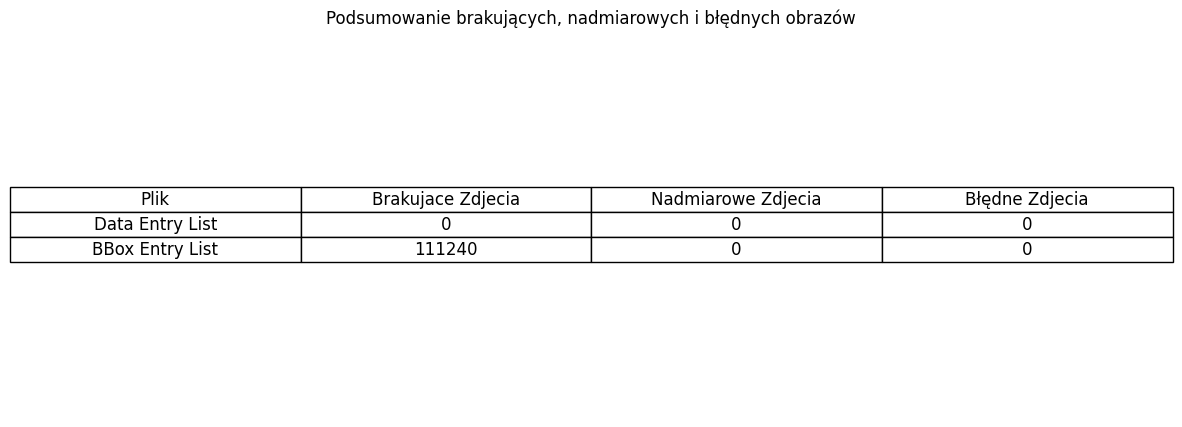

In [14]:
from PIL import Image

# Extract image lists from the metadata
images_in_data_entry = set(data_entry_df['Image Index'])
images_in_bbox_data = set(bounding_box_df['Image Index'])

# Identify missing and extra images
extra_in_data_entry = images_in_data_entry - image_files
missing_in_data_entry = image_files - images_in_data_entry

extra_in_bbox_data = images_in_bbox_data - image_files
missing_in_bbox_data = image_files - images_in_bbox_data

# Check for unreadable images
corrupted_images = []
for directory in matching_dirs:
    nested_dir = f"{directory}/images"
    for image_file in os.listdir(nested_dir):
        image_path = os.path.join(nested_dir, image_file)
        try:
            with Image.open(image_path) as img:
                img.verify()
        except (IOError, SyntaxError):
            corrupted_images.append(image_file)

# Cross-check corrupted images with Data Entry and BBox Entry
corrupted_in_data_entry = set(corrupted_images) & images_in_data_entry
corrupted_in_bbox_data = set(corrupted_images) & images_in_bbox_data

# Create a summary table
summary_table_data = {
    'Plik': ['Data Entry List', 'BBox Entry List'],
    'Brakujace Zdjecia': [len(missing_in_data_entry), len(missing_in_bbox_data)],
    'Nadmiarowe Zdjecia': [len(extra_in_data_entry), len(extra_in_bbox_data)],
    'Błędne Zdjecia': [len(corrupted_in_data_entry), len(corrupted_in_bbox_data)]
}

# Build and display the table
summary_table_df = pd.DataFrame(summary_table_data)
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_table_df.values,
    colLabels=summary_table_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title("Podsumowanie brakujących, nadmiarowych i błędnych obrazów")
plt.show()

Processing Images in /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_006: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.30image/s]
Processing Images in /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_001: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:37<00:00, 133.56image/s]
Processing Images in /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_008: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.32image/s]
Processing Images in /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_009: 100%|████████████████████████████████████████████████████████

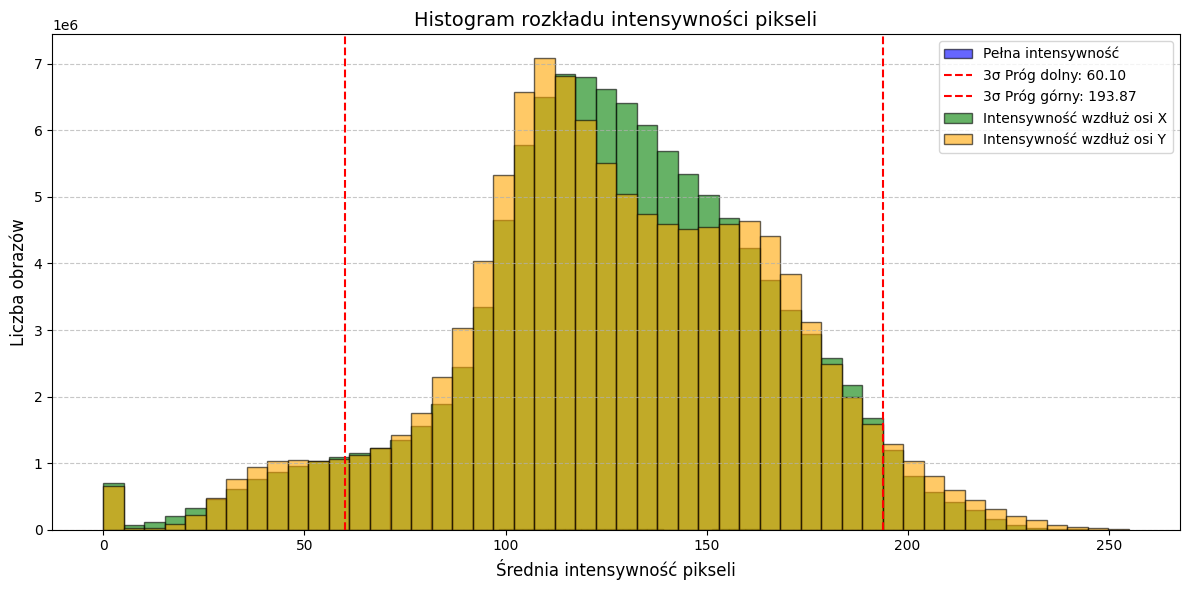

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Initialize lists for mean pixel intensity calculations
pixel_means = []  # Full intensity means
x_means_flat = []  # Intensity means along the x-axis
y_means_flat = []  # Intensity means along the y-axis

# Loop through all directories to process images
for directory in matching_dirs:
    nested_dir = f"{directory}/images"
    image_files_in_dir = os.listdir(nested_dir)

    for image_file in tqdm(image_files_in_dir, desc=f"Processing Images in {directory}", unit="image", leave=True):
        image_path = os.path.join(nested_dir, image_file)
        try:
            img_array = get_image_array(image_path)
    
            # Full image mean intensity
            pixel_means.append(img_array.mean())
    
            # Intensity means along x (columns) and y (rows)
            x_means_flat.extend(img_array.mean(axis=0))  # Mean across rows (vertical intensities)
            y_means_flat.extend(img_array.mean(axis=1))  # Mean across columns (horizontal intensities)
        except Exception as e:
            tqdm.write(f"Error processing {image_file}: {e}")  # Use tqdm.write instead of print
            continue

intensity_mean = np.mean(pixel_means)
intensity_std  = np.std(pixel_means)
lower_bound, upper_bound = standard_deviation_bounds(intensity_mean, intensity_std, 3)

# Plotting three histograms
plt.figure(figsize=(12, 6))
plt.hist(pixel_means, bins=50, alpha=0.6, label='Pełna intensywność', color='blue', edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'3σ Próg dolny: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'3σ Próg górny: {upper_bound:.2f}')

plt.hist(x_means_flat, bins=50, alpha=0.6, label='Intensywność wzdłuż osi X', color='green', edgecolor='black')
plt.hist(y_means_flat, bins=50, alpha=0.6, label='Intensywność wzdłuż osi Y', color='orange', edgecolor='black')

# Add titles and labels
plt.title("Histogram rozkładu intensywności pikseli", fontsize=14)
plt.xlabel("Średnia intensywność pikseli", fontsize=12)
plt.ylabel("Liczba obrazów", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

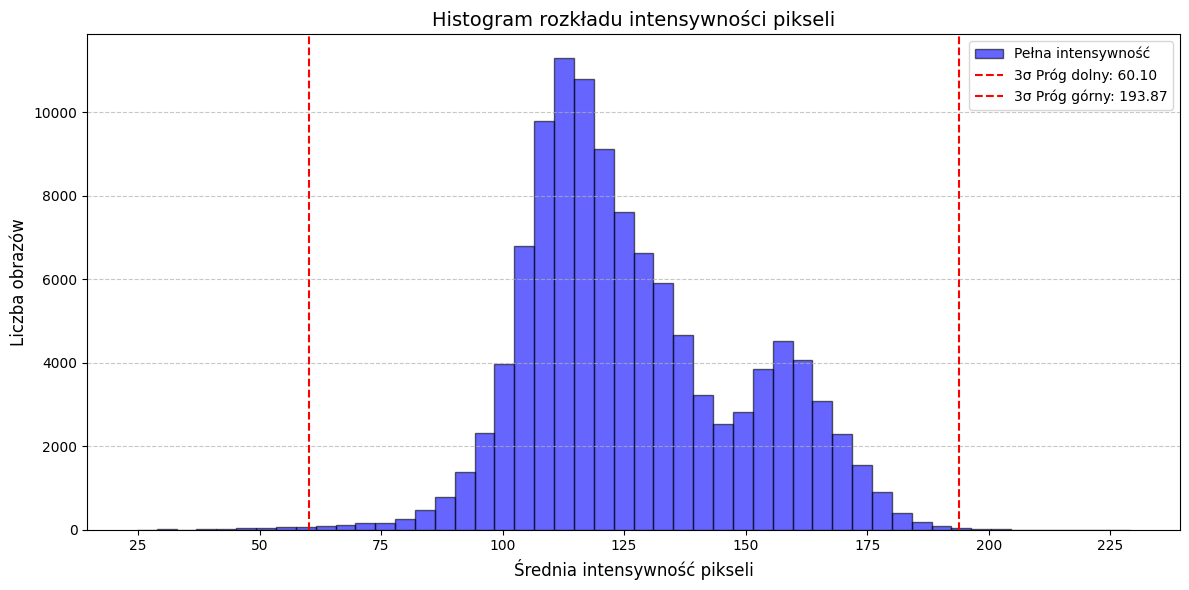

In [16]:
# Mean & Std calculation
intensity_mean = np.mean(pixel_means)
intensity_std  = np.std(pixel_means)
lower_bound, upper_bound = standard_deviation_bounds(intensity_mean, intensity_std, 3)

# Plotting histogram with std
plt.figure(figsize=(12, 6))
plt.hist(pixel_means, bins=50, alpha=0.6, label='Pełna intensywność', color='blue', edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'3σ Próg dolny: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'3σ Próg górny: {upper_bound:.2f}')

# Add titles and labels
plt.title("Histogram rozkładu intensywności pikseli", fontsize=14)
plt.xlabel("Średnia intensywność pikseli", fontsize=12)
plt.ylabel("Liczba obrazów", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
pixel_intensities = []
image_paths = []

# Compute pixel intensities
for directory in matching_dirs:
    nested_dir = f"{directory}/images"
    for image_file in tqdm(os.listdir(nested_dir), desc=f"Calculating Pixel Intensities {directory}"):
        image_path = os.path.join(nested_dir, image_file)
        try:
            img_array = get_image_array(image_path)
            pixel_intensities.append(img_array.mean())  # Store pixel intensity
            image_paths.append(image_path)
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

# Compute median intensity
median_intensity = np.median(pixel_intensities)
print(f"Median pixel intensity: {median_intensity:.2f}")

# Find the reference image (closest to median intensity)
closest_image_index = np.argmin([abs(intensity - median_intensity) for intensity in pixel_intensities])
reference_image_path = image_paths[closest_image_index]
print(f"Reference image: {reference_image_path}")

# Load reference image once
reference_image = get_image_array(reference_image_path)

Calculating Pixel Intensities /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_006: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.68it/s]
Calculating Pixel Intensities /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_001: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:36<00:00, 137.17it/s]
Calculating Pixel Intensities /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_008: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.19it/s]
Calculating Pixel Intensities /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_009: 100%|███████████████████████████████████████████████

Median pixel intensity: 122.03
Reference image: /Users/piotr.r/Projects/codebook/studies/bachelor-thesis/datasets/raw-data/nih-dataset/images_001/images/00000348_000.png


In [ ]:
from skimage.metrics import structural_similarity as ssim
# Compute SSIM for all images
ssim_results = []
for image_path, pixel_intensity in tqdm(zip(image_paths, pixel_intensities), total=len(image_paths), desc="Calculating SSIM"):
    try:
        comparison_image = get_image_array(image_path)

        # Resize if images are not the same size
        if reference_image.shape != comparison_image.shape:
            comparison_image = resize_image(comparison_image, reference_image)

        # Compute SSIM
        ssim_value, _ = ssim(reference_image, comparison_image, full=True)
        ssim_results.append((image_path, ssim_value))

    except Exception as e:
        print(f"Error processing SSIM for {image_path}: {e}")

print("SSIM calculations complete.")

Calculating SSIM:   2%|████▋                                                                                                                                                                                                            | 2498/112120 [02:21<1:40:58, 18.09it/s]

In [ ]:
ssim_values = [result[1] for result in ssim_results]

mean_ssim = np.mean(ssim_values)
std_ssim  = np.std(ssim_values)
lower_bound, upper_bound = standard_deviation_bounds(mean_ssim, std_ssim, 3)


# Rysowanie histogramu SSIM
plt.figure(figsize=(10, 6))
plt.hist(ssim_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram wartości SSIM", fontsize=14)
plt.xlabel("Wartość SSIM", fontsize=12)
plt.ylabel("Liczba obrazów", fontsize=12)
plt.axvline(np.median(ssim_values), color='red', linestyle='--', label='Mediana SSIM')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'3σ Próg dolny: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'3σ Próg górny: {upper_bound:.2f}')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()